# Goal of this notebook

In this notebook, we construct two new features: 

* the analogue of avg_churn, but without using the training or test set to avoiud data leakage
* a variable similar to avg_churn, but for plz_3

More precisely, we will construct a variable called avg_churn_lz, which gives the churn probability for groups
of subscribers with the same lesedauer and zahlung_rhythmus_name. We will compute this variable by using a separate part of the data set that will not be used for training or validation of the models. This avoids data leakage.

We will do the same for plz_3 and construct a new variable called plz_3_prob that also is computed only on a separate part of the data set.


## Import packages and read data

In [1]:
#%reset -fs

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import folium
#from folium.plugins import MarkerCluster



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#import plotly.graph_object as go

%matplotlib inline 
plt.style.use("ggplot")

In [93]:
df = pd.read_csv("f_chtr_churn_traintable_nf_v2.csv")
df.shape

(209043, 171)

# Data cleaning

## Make cut-off for number of subscriptions per subscriber

The original data set contains many subscribers with very high numbers of subscriptions (up to 7000 subscriptions per subscriber). We limit ourselves to subscribers with at most four subscriptions (corresponding to cnt_abo <4, because cnt_abo counts additional subscriptions):

In [94]:
df2=df[df.cnt_abo < 4]
df2.shape

(175130, 171)

## Missing values


The following variables have missing values:
    
    * ort
    * email_am_kunden
    * kuendigungs_eingangs_datum



In [95]:
# Checking for missing values
missing = pd.DataFrame(df2.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/df2.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
ort,85,0.05
email_am_kunden,12,0.01
kuendigungs_eingangs_datum,122166,69.76


Drop the rows with missing values for ort and email_am_kunden. kuendigungs_eingangs_datum will be dropped anyway.
    

In [96]:
df2 = df2.dropna(subset=['ort','email_am_kunden'])
df2=df2.reset_index()
df2.head()

,index,Unnamed: 0,auftrag_new_id,liefer_beginn_evt,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,...,openrate_zeitbrief_1w,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,training_set,kuendigungs_eingangs_datum,churn,date_x
0,3,3,25B535B7-D3F9-4804-9FFE-A8C813C8A593,2013-10-17,andere,ZEIT Digital,Festabo,jährlich,72,0,...,1.0,0.0,0.67,0.0,0.36,0.0,1,NaN,0,2019-10-02 00:00:00
1,4,4,C348C873-8229-4F4F-8B50-5B4C06B2E872,2013-09-12,andere,ZEIT Digital,Festabo,vierteljährlich,70,0,...,0.0,0.0,0.00,0.0,0.00,0.0,1,NaN,0,2019-07-30 00:00:00
2,5,5,15FA7CDA-FDCE-4AB9-A427-0FF8B2D9940F,2013-11-14,andere,ZEIT Digital,Probeabo,jährlich,75,0,...,0.0,0.0,0.00,0.0,0.00,0.0,1,NaN,0,2020-02-26 00:00:00
3,6,6,894FAFB7-6D8C-43CC-82DB-246E0AD1F662,2013-11-14,andere,ZEIT Digital,Probeabo,jährlich,78,0,...,1.0,0.0,0.75,0.0,0.69,0.0,1,NaN,0,2020-05-18 00:00:00
4,7,7,1862C64E-3133-4AD0-B144-E7D8ED69772C,2014-01-02,andere,ZEIT Digital,Probeabo,jährlich,69,0,...,0.0,0.0,0.00,0.0,0.00,0.0,1,NaN,0,2019-10-31 00:00:00


Check that there are no more missing values except for kuendigungs_eingangs_datum:

In [97]:
df2.loc[:,df2.isnull().any()].columns

Index(['kuendigungs_eingangs_datum'], dtype='object')

The old index now appears as another irrelevant feature (index), which we will now drop together with a few other irrelevant or useless features.

## Dropping trivial or irrelevant variables

We drop the following variables:
    
    * index (no useful information)
    * Unnamed: 0 (no useful information)
    * auftrag_new_id (no useful information)
    * kuendigungs_eingangs_datum (would tell us who would churn, because those who don't churn have nan here)
    * training_set (no useful information)
    * date_x 
                                  

                                  
                                  


In [98]:
drop=['index', 'Unnamed: 0', 'auftrag_new_id',
      'training_set','kuendigungs_eingangs_datum', 'date_x']
df2=df2.drop(drop, axis=1)

## Transforming temporal variables

For the EDA, we have to convert the remaining temporal variables that are not yet numbers to suitable numbers:

    * liefer_beginn_evt
    * abo_registrierung_min
    * nl_registrierung_min



In [99]:
df2['liefer_beginn_num']= df2['liefer_beginn_evt'].str[:4].astype('int')  +df2['liefer_beginn_evt'].str[5:7].astype('float')/12 #+ df2['liefer_beginn_evt'].str[8:10].astype('float')/365 
df2['abo_registrierung_min_year']= df2['abo_registrierung_min'].str[:4].astype('int')  
df2['nl_registrierung_min_year']= df2['nl_registrierung_min'].str[:4].astype('int') 

df2=df2.drop(['liefer_beginn_evt','abo_registrierung_min','nl_registrierung_min'
             ], axis=1)
df2[['liefer_beginn_num', 'abo_registrierung_min_year', 'nl_registrierung_min_year'
    ]].head()


,liefer_beginn_num,abo_registrierung_min_year,nl_registrierung_min_year
0,2013.833333,2013,2013
1,2013.750000,1900,2013
2,2013.916667,2013,2013
3,2013.916667,2013,2013
4,2014.083333,2013,2008


# Exploratory data analysis

In the following, we will plot the churn probability by value of selected features. To this end, 
we introduce a dummy variable for the two possible churn values 0 and 1 to facilitate the counting. As we will use this only for EDA, we will
define a new data frame df_a. df2 will later be used for model building again. 

In [100]:

dummy0 = pd.get_dummies(df2['churn'],prefix='churn')

In [101]:

df_a = pd.concat([df2,dummy0], axis =1)

We first determine the overall churn probability in the entire data set:

In [102]:
df_a['churn_1'].sum()/(df_a['churn_1'].sum() + df_a['churn_0'].sum())

0.30223656773972407

The total churn probability in the entire dataset is thus:

**30.2%**

# Data preprocessing

## Binning of abo_registrierung_min_year and nl_registrierung_min_year

The variables abo_registrierung_min_year and nl_registrierung_min_year should be turned into  dummy variables as 
they contain the artificial year 1900. abo_registrierung_min_year, however, contains so many years that it should 
be binned. We choose 13 bins such that the classes have somewhat comparable size: 

In [103]:
df2['abo_registrierung_min_year_binned']= df2['abo_registrierung_min_year'].apply(
    lambda x: 0 if x==1900 else x).apply(
    lambda x:1 if 1900 < x <=1996 else x).apply(
    lambda x: 2 if 1996 < x <= 2002 else x).apply(
    lambda x: 3 if 2002 < x <= 2007 else x).apply(
    lambda x: 4 if 2007 < x <=2010 else x).apply(
    lambda x: 5 if 2010 < x <= 2012 else x ).apply(
    lambda x : x-2007 if x>2012 else x)

In [104]:
df2['abo_registrierung_min_year_binned'].value_counts()

0     23630
11    22273
10    18574
9     14753
6     13488
8     12783
7     12322
5     11193
4     10638
3     10388
1      9148
12     8838
2      7017
Name: abo_registrierung_min_year_binned, dtype: int64

For nl_registrierung_min_year, we choose 12 bins:

In [105]:
df2['nl_registrierung_min_year_binned']= df2['nl_registrierung_min_year'].apply(
    lambda x: 0 if x==1900 else x).apply(
    lambda x:1 if 1900 < x <=2005 else x).apply(
    lambda x: 2 if 2005 < x <= 2009 else x).apply(
    lambda x: 3 if 2009 < x <= 2011 else x).apply(
    lambda x : x-2008 if x>=2012 else x)

In [106]:
df2['nl_registrierung_min_year_binned'].value_counts()

9     21312
10    19653
2     17433
3     16022
8     14774
1     14030
7     14028
5     13859
6     13684
0     11808
4     10174
11     7567
12      701
Name: nl_registrierung_min_year_binned, dtype: int64

We will drop the unbinned variables abo_registrierung_min_year and nl_registrierung_min_year in the next subsection.

## Dropping ort, abo_registrierung_min_year, nl_registrierung_min_year


Before we introduce dummy variables for the categorical features, we drop

    * ort 
    
    and the unbinned variables
    
    * abo_registrierung_min_year
    * nl_registrierung_min_year

In [107]:
df2=df2.drop(['ort','abo_registrierung_min_year', 'nl_registrierung_min_year'], axis=1)

## Feature engineering

### Splitting off an exploratory data set

We split off an exploratory data set in which we can compute avg_churn etc. without data leakage.
We do this by splitting df2 into X2, y2 and then using train_test_split to split X2 into X2_main and X2_exp and y2 into 
y2_main and y2_exp. Then we concatenate X2_main and y2_main to df2_main and X2_exp and y2_exp to df2_exp.

df2_main will then be used for training and testing, whereas df2_exp will be entirely used for computing the 
new variables. The concatenation to df2_exp is necessary because we need churn (i.e. y2_exp) and the features
lesedauer, zahlung_rhythmus_name and plz_3 (i.e. X2_exp) 
to compute the churn probabilities for those variables.

In [108]:

X2 = df2.drop('churn', axis=1)
y2 = df2['churn']
print(X2.shape)
print(y2.shape)

(175045, 164)
(175045,)


In [109]:

X2_main, X2_exp, y2_main, y2_exp = train_test_split(X2, y2, stratify = y2, test_size=0.2, random_state=7)

print(X2_main.shape)
print(y2_main.shape)
print(X2_exp.shape)
print(y2_exp.shape)

(140036, 164)
(140036,)
(35009, 164)
(35009,)


In [110]:
df2_exp = pd.concat([X2_exp,y2_exp], axis = 1)

In [111]:
df2_main = pd.concat([X2_main,y2_main], axis = 1)

### Constructing the new variable avg_churn_lz from lesedauer and zahlung_rhythmus_name

We check how many subscribers we have in each category of zahlung_rhythmus_name

In [112]:
df2_exp['zahlung_rhythmus_name'].value_counts()

jährlich                22424
halbjährlich             8361
vierteljährlich          4096
monatlich                 109
zweijährlich               16
einmalige Berechnung        3
Name: zahlung_rhythmus_name, dtype: int64

Obviously, zweijährlich and einmalige Berechnung have not enough people to make a useful statistics with them.
But also monatlich does not have enough subscribers, because we have to further split them according to lesedauer, 
which then leaves only very few people in each category. We do this now for monatlich.

In [113]:
df2_exp[df2_exp['zahlung_rhythmus_name'] == 'monatlich']['lesedauer'].value_counts()

27    7
12    7
5     5
16    4
8     4
17    4
10    4
32    4
15    4
31    3
21    3
4     3
26    3
6     3
37    3
28    2
19    2
24    2
35    2
39    2
38    2
41    2
42    2
13    2
47    2
48    2
11    2
51    2
18    1
9     1
7     1
20    1
83    1
22    1
50    1
78    1
73    1
61    1
57    1
54    1
52    1
49    1
23    1
46    1
36    1
34    1
33    1
80    1
25    1
29    1
Name: lesedauer, dtype: int64

To ensure reasonable statistics, we will set a filter that ensures that we have at least eight 
subscribers in each category. From the above list, we see that the value monatlich has at most 
seven subscribers in each category if we split everything also according to lesedauer. Thus, 
the filter will effectively truncate out the value monatlich. More precisely, we will not compute
churn probabilities for subscribers with monatlich as zahlung_rhythmus_name. The same will be true
for zweijährlich uind einmalige Berechnung. For those subscribers, we will simply use an imputer
to give them the median churn probability. Due to the small number of subscribers in these 
categories, this will not affect much the result.

Before we can compute churn probabilities, we introduce a dummy variable for churn in df2_exp as that will make counting easier. The resulting data frame will be called df2_exp_a.

In [114]:


dummy0 = pd.get_dummies(df2_exp['churn'],prefix='churn')


df2_exp_a = pd.concat([df2_exp,dummy0], axis =1)




In [115]:
df2_exp_a.head()

,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,...,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,liefer_beginn_num,abo_registrierung_min_year_binned,nl_registrierung_min_year_binned,churn,churn_0,churn_1
59861,Standwerbung,DIE ZEIT,Negative Option,jährlich,37,0,Rechnung,0,4,48,...,0.0,0.0,0.0,0.0,2016.916667,9,12,1,0,1
130256,andere,ZEIT Digital,Festabo,jährlich,19,0,Rechnung,0,1,10,...,0.0,0.0,0.0,0.0,2018.000000,10,9,0,1,0
127793,Telefonmarketing,DIE ZEIT,Festabo,vierteljährlich,14,0,Bankeinzug,0,2,22,...,0.0,0.0,0.0,0.0,2019.000000,10,4,0,1,0
89690,Mailings,ZEIT Digital,Festabo,jährlich,45,0,Rechnung,0,6,66,...,0.0,0.0,0.0,0.0,2016.416667,1,1,0,1,0
169626,andere,ZEIT Digital,Negative Option,jährlich,11,0,Rechnung,0,xx,xx,...,0.0,0.0,0.0,0.0,2019.166667,0,7,0,1,0


We now compute the churn probability, q, for each subgroup of the variables lesedauer and 
zahlung_rhythmus_name that has at least eight subscribers. To this end, we introduce the new 
data frame df_b, in which all entries are grouped by lesedauer and zahlung_rhythmus_name. 
We then compute the sum of people with churn =1 and churn =0 separately for wach category. 
These sums are then used to compute the churn probability q for each subcategory. We then reorder the table 
according to q and reset the index. We then get a table from which we can read off q for each combination 
of lesedauer and zahlung_rhythmus_name with at least eight subscribers. 

In [116]:
df_b=df2_exp_a.groupby(['lesedauer','zahlung_rhythmus_name']).agg({'churn_1': 'sum',
                'churn_0': 'sum'})
#df_b.describe()

df_b.columns = ['churn_1_sum', 'churn_0_sum'] #["_".join(x) for x in df_b.columns.ravel()]

df_b=df_b.reset_index()
#df_b.head()

df_b["q"]=(round(df_b["churn_1_sum"]/(df_b["churn_0_sum"]+df_b["churn_1_sum"]), 3))*100
df_b=df_b.sort_values(by="q")
df_b=df_b[(df_b['churn_1_sum']+df_b['churn_0_sum'])>8].sort_values(by="q")
df_b=df_b.reset_index()
df_b

,index,lesedauer,zahlung_rhythmus_name,churn_1_sum,churn_0_sum,q
0,240,60,halbjährlich,0.0,9.0,0.0
1,332,88,jährlich,0.0,13.0,0.0
2,319,84,halbjährlich,0.0,14.0,0.0
3,328,87,halbjährlich,0.0,9.0,0.0
4,298,78,halbjährlich,1.0,28.0,3.4
5,295,77,halbjährlich,1.0,27.0,3.6
6,304,79,vierteljährlich,2.0,31.0,6.1
7,286,74,halbjährlich,2.0,26.0,7.1
8,309,81,halbjährlich,2.0,25.0,7.4
9,215,53,vierteljährlich,2.0,24.0,7.7


The relevant information in df_b is in lesedauer, zahlung_rhythmus_name and q, which 
we collect in a smaller data frame df_b_small:

In [117]:
df_b_small = df_b[['lesedauer', 'zahlung_rhythmus_name','q']]

In [118]:
df_b_small

,lesedauer,zahlung_rhythmus_name,q
0,60,halbjährlich,0.0
1,88,jährlich,0.0
2,84,halbjährlich,0.0
3,87,halbjährlich,0.0
4,78,halbjährlich,3.4
5,77,halbjährlich,3.6
6,79,vierteljährlich,6.1
7,74,halbjährlich,7.1
8,81,halbjährlich,7.4
9,53,vierteljährlich,7.7


We rename q to avg_churn_lz. This variable will be our properly computed analogue of avg_churn.

In [119]:
df_b_small.rename(columns={'q':'avg_churn_lz'},inplace = True)

/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [120]:
df_b_small

,lesedauer,zahlung_rhythmus_name,avg_churn_lz
0,60,halbjährlich,0.0
1,88,jährlich,0.0
2,84,halbjährlich,0.0
3,87,halbjährlich,0.0
4,78,halbjährlich,3.4
5,77,halbjährlich,3.6
6,79,vierteljährlich,6.1
7,74,halbjährlich,7.1
8,81,halbjährlich,7.4
9,53,vierteljährlich,7.7


df_b_small is our dictionary that tells us which avg_churn_lz corresponds to which combination of 
lesedauer and zahlung_rhythmus_name. This information now has to be implemented also in df2_main,
which we will use for machine learning. This will be done with merge.

In [121]:
df2_main=pd.merge(df2_main,df_b_small,on=['lesedauer','zahlung_rhythmus_name'], how='left')


In [122]:
df2_main.head(47)

,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,...,clickrate_zeitbrief_1w,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,liefer_beginn_num,abo_registrierung_min_year_binned,nl_registrierung_min_year_binned,churn,avg_churn_lz
0,Affiliate,DIE ZEIT,Negative Option,jährlich,78,0,Bankeinzug,0,4,42,...,0.0,0.40,0.0,0.57,0.00,2013.833333,6,5,0,11.9
1,andere,DIE ZEIT,Probeabo,jährlich,11,0,Rechnung,0,4,49,...,0.0,0.75,0.0,0.69,0.00,2018.833333,11,10,1,61.8
2,Telefonmarketing,DIE ZEIT,Geschenkabo,vierteljährlich,36,0,Rechnung,0,5,53,...,0.0,0.00,0.0,0.00,0.00,2016.666667,9,3,0,43.8
3,andere,DIE ZEIT,Negative Option,halbjährlich,19,0,Rechnung,0,5,50,...,0.0,0.00,0.0,0.00,0.00,2018.750000,9,8,0,47.6
4,andere,DIE ZEIT,Festabo,jährlich,69,0,Bankeinzug,0,6,67,...,0.0,0.00,0.0,0.00,0.00,2014.083333,6,5,0,17.0
5,andere,DIE ZEIT,Prämienabo,jährlich,66,0,Bankeinzug,0,1,16,...,0.0,0.00,0.0,0.00,0.00,2014.916667,7,2,0,14.0
6,E-Mailing,ZEIT Digital,Festabo,jährlich,32,0,Bankeinzug,0,0,04,...,0.0,0.00,0.0,0.00,0.00,2017.083333,7,2,0,14.7
7,E-Mailing,DIE ZEIT,Negative Option,halbjährlich,17,0,Rechnung,0,3,33,...,0.0,0.25,1.0,0.38,0.20,2018.666667,2,1,0,42.8
8,Fremdwerbung,DIE ZEIT,Negative Option,jährlich,50,0,Rechnung,0,xx,xx,...,0.0,0.00,0.0,0.00,0.00,2016.000000,0,0,0,16.0
9,andere,ZEIT Digital,Probeabo,jährlich,18,0,Bankeinzug,0,6,66,...,0.0,1.00,0.0,1.00,0.00,2018.916667,11,9,0,20.5


We have now successfully computed the new variable avg_churn_lz for our data set. However, 
due to our filter of at least eight subscribers for each subcategory, there will be some missing 
values for all those subgroups with less than eight subscribers. 

In [123]:
missing = pd.DataFrame(df2_main.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df2_main.shape[0] * 100, 1)
missing[missing.Number != 0]

,Number,Percentage
avg_churn_lz,749,0.5


We will impute them later together 
with the missing values for the other new variable we will construct for plz_3.

In [124]:
df2_main.shape

(140036, 166)

### The new variable plz_3_prob from plz_3

We now proceed as above for avg_churn_lz and compute a new variable plz_3_prob, which gives the churn 
probability for each plz_3 value that has at least eight subscribers in the data set df2_exp:

In [125]:
df_b=df2_exp_a.groupby('plz_3').agg({'churn_1': 'sum',
                'churn_0': 'sum'})
#df_b.describe()

df_b.columns = ['churn_1_sum', 'churn_0_sum'] #["_".join(x) for x in df_b.columns.ravel()]

df_b=df_b.reset_index()
#df_b.head()

df_b["q"]=(round(df_b["churn_1_sum"]/(df_b["churn_0_sum"]+df_b["churn_1_sum"]), 3))*100
df_b=df_b.sort_values(by="q")
df_b=df_b[(df_b['churn_1_sum']+df_b['churn_0_sum'])>8].sort_values(by="q")
df_b=df_b.reset_index()
df_b

,index,plz_3,churn_1_sum,churn_0_sum,q
0,630,924,0.0,10.0,0.0
1,637,934,0.0,11.0,0.0
2,25,048,0.0,10.0,0.0
3,199,320,0.0,11.0,0.0
4,381,573,1.0,17.0,5.6
5,590,864,2.0,29.0,6.5
6,574,837,1.0,12.0,7.7
7,666,979,2.0,23.0,8.0
8,352,534,2.0,21.0,8.7
9,93,165,3.0,29.0,9.4


Again, we form df_b_small as the dictionary between plz_3 and q:

In [126]:
df_b_small = df_b[['plz_3','q']]

In [127]:
df_b_small

,plz_3,q
0,924,0.0
1,934,0.0
2,048,0.0
3,320,0.0
4,573,5.6
5,864,6.5
6,837,7.7
7,979,8.0
8,534,8.7
9,165,9.4


We call q now plz_3_prob:

In [128]:
df_b_small.rename(columns={'q':'plz_3_prob'},inplace = True)

In [129]:
df_b_small

,plz_3,plz_3_prob
0,924,0.0
1,934,0.0
2,048,0.0
3,320,0.0
4,573,5.6
5,864,6.5
6,837,7.7
7,979,8.0
8,534,8.7
9,165,9.4


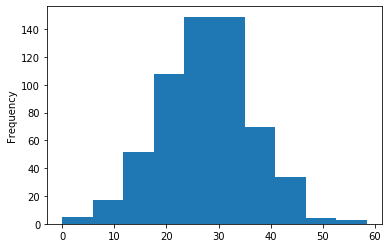

In [130]:
df_b_small['plz_3_prob'].plot(kind='hist')

The histogram shows that plz_3_prob is approximately Gaussian. We now implement the new variable plz_3_prob also in df2_main with merge:

In [131]:
df2_main=pd.merge(df2_main,df_b_small,on='plz_3', how='left')


In [132]:
df2_main.head(47)

,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,...,openrate_zeitbrief_1m,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,liefer_beginn_num,abo_registrierung_min_year_binned,nl_registrierung_min_year_binned,churn,avg_churn_lz,plz_3_prob
0,Affiliate,DIE ZEIT,Negative Option,jährlich,78,0,Bankeinzug,0,4,42,...,0.40,0.0,0.57,0.00,2013.833333,6,5,0,11.9,34.5
1,andere,DIE ZEIT,Probeabo,jährlich,11,0,Rechnung,0,4,49,...,0.75,0.0,0.69,0.00,2018.833333,11,10,1,61.8,41.4
2,Telefonmarketing,DIE ZEIT,Geschenkabo,vierteljährlich,36,0,Rechnung,0,5,53,...,0.00,0.0,0.00,0.00,2016.666667,9,3,0,43.8,24.7
3,andere,DIE ZEIT,Negative Option,halbjährlich,19,0,Rechnung,0,5,50,...,0.00,0.0,0.00,0.00,2018.750000,9,8,0,47.6,32.6
4,andere,DIE ZEIT,Festabo,jährlich,69,0,Bankeinzug,0,6,67,...,0.00,0.0,0.00,0.00,2014.083333,6,5,0,17.0,27.0
5,andere,DIE ZEIT,Prämienabo,jährlich,66,0,Bankeinzug,0,1,16,...,0.00,0.0,0.00,0.00,2014.916667,7,2,0,14.0,20.0
6,E-Mailing,ZEIT Digital,Festabo,jährlich,32,0,Bankeinzug,0,0,04,...,0.00,0.0,0.00,0.00,2017.083333,7,2,0,14.7,41.5
7,E-Mailing,DIE ZEIT,Negative Option,halbjährlich,17,0,Rechnung,0,3,33,...,0.25,1.0,0.38,0.20,2018.666667,2,1,0,42.8,25.0
8,Fremdwerbung,DIE ZEIT,Negative Option,jährlich,50,0,Rechnung,0,xx,xx,...,0.00,0.0,0.00,0.00,2016.000000,0,0,0,16.0,36.9
9,andere,ZEIT Digital,Probeabo,jährlich,18,0,Bankeinzug,0,6,66,...,1.00,0.0,1.00,0.00,2018.916667,11,9,0,20.5,21.0


We now take care of the missing values:

In [133]:
missing = pd.DataFrame(df2_main.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df2_main.shape[0] * 100, 1)
missing[missing.Number != 0]

,Number,Percentage
avg_churn_lz,749,0.5
plz_3_prob,1880,1.3


We replace them with the median:

In [134]:
m1=df2_main.avg_churn_lz.median()
df2_main.avg_churn_lz.fillna(m1, inplace=True)

m2=df2_main.plz_3_prob.median()
df2_main.plz_3_prob.fillna(m2, inplace=True)

In [135]:
missing = pd.DataFrame(df2_main.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df2_main.shape[0] * 100, 1)
missing[missing.Number != 0]

,Number,Percentage


Note that we have used the median for df2_main, which will contain training and test set. 
This may introduce
data leakage, but we have checked that properly splitting into test and training
data set before taking the medians will not lead to significant changes.

### plz_3_prob_binned

We use also a binned version of plz_3_prob, which we will call plz_3_prob_binned. The following binning turns 
out to give rather good correlations with churn:

In [136]:
df2_main['plz_3_prob_binned']= df2_main['plz_3_prob'].apply(
    lambda x: 0 if 0<=x<28 else x).apply(
    lambda x:1 if 28<=  x <36 else x).apply(
    lambda x: 2 if 36 <= x <=100 else x)#.apply(
    #lambda x: 3 if 38 <= x <45 else x).apply(
    #lambda x: 4 if 45 <= x <=100 else x)#.apply(
    #lambda x: 0 if 0<=x<20 else x).apply(
    #lambda x:1 if 20<=  x <25 else x).apply(
    #lambda x: 2 if 25 <= x < 28 else x).apply(
    #lambda x: 3 if 28 <= x < 31 else x).apply(
    #lambda x: 4 if 31 <= x <35 else x).apply(
    #lambda x: 5 if 35<=  x < 37 else x ).apply(
    #lambda x : 6 if 37<= x  <41 else x).apply(
    #lambda x : 7 if 31<= x  <=100 else x)

In [137]:
df2_main['plz_3_prob_binned'].value_counts()


1.0    49757
0.0    49707
2.0    40572
Name: plz_3_prob_binned, dtype: int64

### The correlation with churn

We now check how strongly our new variables correlate with churn compared to the other variables.

In [138]:
corr_matrix = df2_main.corr()


In [139]:
corr_matrix['churn']

lesedauer                           -0.233594
rechnungsmonat                       0.088749
studentenabo                         0.104400
metropole                            0.039944
shop_kauf                           -0.068562
unterbrechung                       -0.006524
avg_churn                            0.314783
email_am_kunden                      0.023560
zon_che_opt_in                       0.006302
zon_sit_opt_in                       0.013603
zon_zp_grey                          0.038827
zon_premium                          0.005729
zon_boa                              0.015972
zon_kommentar                        0.008685
zon_sonstige                         0.019641
zon_zp_red                           0.035731
zon_rawr                            -0.003747
zon_community                        0.005448
zon_app_sonstige                     0.008102
zon_schach                          -0.000067
zon_blog_kommentare                  0.004279
zon_quiz                          

We are more interested in the absolute values of the correlation, so we rank the correlations 
according to their absolute value.

In [140]:
df2_main_corr=pd.DataFrame(corr_matrix['churn'])

In [141]:
df2_main_corr['abs_corr'] = df2_main_corr['churn'].apply(np.abs)

In [142]:
df2_main_corr['abs_corr'].sort_values(ascending=False).head(47)

churn                                1.000000
avg_churn                            0.314783
avg_churn_lz                         0.312613
lesedauer                            0.233594
liefer_beginn_num                    0.230670
nl_registrierung_min_year_binned     0.177090
nl_aktivitaet                        0.160257
abo_registrierung_min_year_binned    0.142499
nl_zeitshop                          0.113572
studentenabo                         0.104400
cnt_umwandlungsstatus2_dkey          0.102017
rechnungsmonat                       0.088749
received_anzahl_1m                   0.078808
received_anzahl_6m                   0.077723
received_anzahl_3m                   0.077687
openedanzahl_6m                      0.076065
opened_anzahl_3m                     0.075643
plz_3_prob_binned                    0.075061
received_anzahl_1w                   0.074367
plz_3_prob                           0.071308
opened_anzahl_1m                     0.070333
shop_kauf                         

We see that avg_churn_lz and avg_churn have almost the same correlation with churn. Thus, if there is some 
data leakage in the old computation of avg_churn, it is not that big. Moreover, avg_churn_lz has a rather 
high correlation with churn. plz_3_prob has a correlation of 0.07, whereas plz_3_prob_binned has a correlation 
of 0.075. However, this slight improvement over plz_3_prob is very sensitive to the thresholds for the binning
so that we will stick to plz_3_prob.

In [143]:
df2_main.head()

,kanal,objekt_name,aboform_name,zahlung_rhythmus_name,lesedauer,rechnungsmonat,zahlung_weg_name,studentenabo,plz_1,plz_2,...,clickrate_zeitbrief_1m,openrate_zeitbrief_3m,clickrate_zeitbrief_3m,liefer_beginn_num,abo_registrierung_min_year_binned,nl_registrierung_min_year_binned,churn,avg_churn_lz,plz_3_prob,plz_3_prob_binned
0,Affiliate,DIE ZEIT,Negative Option,jährlich,78,0,Bankeinzug,0,4,42,...,0.0,0.57,0.0,2013.833333,6,5,0,11.9,34.5,1.0
1,andere,DIE ZEIT,Probeabo,jährlich,11,0,Rechnung,0,4,49,...,0.0,0.69,0.0,2018.833333,11,10,1,61.8,41.4,2.0
2,Telefonmarketing,DIE ZEIT,Geschenkabo,vierteljährlich,36,0,Rechnung,0,5,53,...,0.0,0.00,0.0,2016.666667,9,3,0,43.8,24.7,0.0
3,andere,DIE ZEIT,Negative Option,halbjährlich,19,0,Rechnung,0,5,50,...,0.0,0.00,0.0,2018.750000,9,8,0,47.6,32.6,1.0
4,andere,DIE ZEIT,Festabo,jährlich,69,0,Bankeinzug,0,6,67,...,0.0,0.00,0.0,2014.083333,6,5,0,17.0,27.0,0.0


**Categorical features**

Categorical features are the ones of type 'object' 
and several variables that have numerical values, but are nevertheless categorical:

In [144]:
# Creating list for categorical predictors/features 
cat_features = list(df2_main.columns[df2_main.dtypes==object])
# Extend the list by those categorical features that are already given in terms of numbers
cat_features.extend(['rechnungsmonat','metropole','studentenabo','unterbrechung','email_am_kunden',
       'zon_che_opt_in', 'zon_sit_opt_in', 'zon_zp_grey', 'zon_premium',
       'zon_boa', 'zon_kommentar', 'zon_sonstige', 'zon_zp_red',
       'zon_rawr', 'zon_community', 'zon_app_sonstige', 'zon_schach',
       'zon_blog_kommentare', 'zon_quiz','nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg',
       'nl_fdz_organisch','boa_reg', 'che_reg', 'sit_reg', 'sso_reg','abo_registrierung_min_year_binned', 
                     'nl_registrierung_min_year_binned',
                    ])
cat_features

['kanal',
 'objekt_name',
 'aboform_name',
 'zahlung_rhythmus_name',
 'zahlung_weg_name',
 'plz_1',
 'plz_2',
 'plz_3',
 'land_iso_code',
 'anrede',
 'titel',
 'rechnungsmonat',
 'metropole',
 'studentenabo',
 'unterbrechung',
 'email_am_kunden',
 'zon_che_opt_in',
 'zon_sit_opt_in',
 'zon_zp_grey',
 'zon_premium',
 'zon_boa',
 'zon_kommentar',
 'zon_sonstige',
 'zon_zp_red',
 'zon_rawr',
 'zon_community',
 'zon_app_sonstige',
 'zon_schach',
 'zon_blog_kommentare',
 'zon_quiz',
 'nl_zeitbrief',
 'nl_zeitshop',
 'nl_zeitverlag_hamburg',
 'nl_fdz_organisch',
 'boa_reg',
 'che_reg',
 'sit_reg',
 'sso_reg',
 'abo_registrierung_min_year_binned',
 'nl_registrierung_min_year_binned']

In [145]:
# Creating list for numerical features
num_features = list(df2_main.columns)
for i in cat_features:
    num_features.remove(i)
num_features.remove('churn')    

num_features

['lesedauer',
 'shop_kauf',
 'avg_churn',
 'cnt_abo',
 'cnt_abo_diezeit',
 'cnt_abo_diezeit_digital',
 'cnt_abo_magazin',
 'cnt_umwandlungsstatus2_dkey',
 'nl_blacklist_sum',
 'nl_bounced_sum',
 'nl_aktivitaet',
 'nl_sperrliste_sum',
 'nl_opt_in_sum',
 'received_anzahl_1w',
 'received_anzahl_1m',
 'received_anzahl_3m',
 'received_anzahl_6m',
 'opened_anzahl_1w',
 'opened_anzahl_1m',
 'opened_anzahl_3m',
 'openedanzahl_6m',
 'clicked_anzahl_1w',
 'clicked_anzahl_1m',
 'clicked_anzahl_3m',
 'clicked_anzahl_6m',
 'unsubscribed_anzahl_1w',
 'unsubscribed_anzahl_1m',
 'unsubscribed_anzahl_3m',
 'unsubscribed_anzahl_6m',
 'openrate_1w',
 'clickrate_1w',
 'openrate_1m',
 'clickrate_1m',
 'openrate_3m',
 'clickrate_3m',
 'received_anzahl_bestandskunden_1w',
 'received_anzahl_bestandskunden_1m',
 'received_anzahl_bestandskunden_3m',
 'received_anzahl_bestandskunden_6m',
 'opened_anzahl_bestandskunden_1w',
 'opened_anzahl_bestandskunden_1m',
 'opened_anzahl_bestandskunden_3m',
 'openedanzahl_bes

We do not use the pipeline method for creating the dummies, as we would like to maintain maximum flexibility 
regarding the selection of features:

In [146]:
df2_main_d = df2_main
df2_main_d=pd.get_dummies(df2_main_d,columns=cat_features, drop_first=True)
df2_main_d.head()

,lesedauer,shop_kauf,avg_churn,cnt_abo,cnt_abo_diezeit,cnt_abo_diezeit_digital,cnt_abo_magazin,cnt_umwandlungsstatus2_dkey,nl_blacklist_sum,nl_bounced_sum,...,nl_registrierung_min_year_binned_3,nl_registrierung_min_year_binned_4,nl_registrierung_min_year_binned_5,nl_registrierung_min_year_binned_6,nl_registrierung_min_year_binned_7,nl_registrierung_min_year_binned_8,nl_registrierung_min_year_binned_9,nl_registrierung_min_year_binned_10,nl_registrierung_min_year_binned_11,nl_registrierung_min_year_binned_12
0,78,0,0.114840,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,11,0,0.610627,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,36,0,0.309526,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,19,1,0.427970,3,2,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,69,0,0.172727,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Splitting into target and predictor variables and test, validation and training set

In [147]:
# Define predictors and target variable
X = df2_main_d.drop('churn', axis=1)
y = df2_main_d['churn']
print(X.shape)
print(y.shape)

(140036, 1025)
(140036,)


To keep computing time short enough for parameter tunings, we will do many computations with a 
training and a validation set and use the slower cross validation with a pipeline only at a later step
to verify that no overfitting occurs, in case that should appear necessary. 
At the final stage, we will test our best models on a test set. To 
be able to do this, we carry out the following splitting:
    
    X -> X_train_cv, X_test 
    y -> y_train_cv, y_test
    
    X_train_cv -> X_train, X_val
    y_train_cv -> y_train, y_val
    
If one wants to use cross validation with scaling in a pipeline, this could be done with X_train_cv and y_train_cv, which we therefore do not scale.

X_train and X_val, on the other hand, will be separately scaled and used together with y_train and y_val to train and tune and 
evaluate models without pipelines.   
    


Only at the very end we test the best models also on the test data set X_test, y_test, which will remain 
untouched until then and also scaled separately.


In [148]:
# Split into train/cross-validation and test set
X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=7)

print(X_train_cv.shape)
print(y_train_cv.shape)
print(X_test.shape)
print(y_test.shape)

(112028, 1025)
(112028,)
(28008, 1025)
(28008,)


In [149]:
# Split into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_cv, y_train_cv, stratify = y_train_cv, test_size=0.2, random_state=7)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(89622, 1025)
(89622,)
(22406, 1025)
(22406,)


## Scaling of numerical features

In [150]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train[num_features])
X_train_scaled = X_train
X_train_scaled[num_features] = scaler.transform(X_train[num_features])
X_val_scaled = X_val
X_val_scaled[num_features] = scaler.transform(X_val[num_features])
X_test_scaled = X_test
X_test_scaled[num_features] = scaler.transform(X_test_scaled[num_features])

/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/marcozagermann/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

# Models with the new variables

## The new feature sets

In the notebook Capstone_main, we used three different methods for feature selection which 
resulted
in twelve feature sets (20a, 30a, 20a2,20a3, 20b,30b,20b2,20b3, 20c,30c,20c2,20c3). Out of 
these we selected 20a, 20a2, 30b, 20c2 as the most promising ones.
We now reconsider 
the most successful models with the additional features avg_churn_lz and plz_3_prob, which
we have constructed above. Instead of going through the whole feature selection process again,
we will simply add these two new features to the old feature sets and call them 20an, 20a2n, 
30bn, 20c2n, even though these feature sets now have 22 or 32 features. The resulting new lists of 
features are:

In [151]:
l20a2n=['lesedauer',
 'zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'zahlung_rhythmus_name_jährlich',
 'abo_registrierung_min_year_binned_11',
 'nl_registrierung_min_year_binned_10',
 'aboform_name_Negative Option',
 'abo_registrierung_min_year_binned_12',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop_2',
 'abo_registrierung_min_year_binned_1',
 'studentenabo_1',
 'nl_registrierung_min_year_binned_11',
 'cnt_umwandlungsstatus2_dkey',
 'nl_registrierung_min_year_binned_1',
 'rechnungsmonat_1',
 'kanal_Mailings',
 'abo_registrierung_min_year_binned_2',
 'received_anzahl_1m',
 'openedanzahl_6m', 'avg_churn_lz', 'plz_3_prob']

In [152]:
l20an = ['lesedauer', 'liefer_beginn_num',
       'zahlung_weg_name_Rechnung', 'nl_aktivitaet',
       'zahlung_rhythmus_name_jährlich', 'zahlung_rhythmus_name_halbjährlich',
       'abo_registrierung_min_year_binned_11',
       'nl_registrierung_min_year_binned_10', 'aboform_name_Negative Option',
       'abo_registrierung_min_year_binned_12', 'objekt_name_ZEIT Digital',
       'nl_zeitshop_2', 'abo_registrierung_min_year_binned_1',
       'studentenabo_1', 'nl_registrierung_min_year_binned_11',
       'cnt_umwandlungsstatus2_dkey', 'nl_registrierung_min_year_binned_1',
       'rechnungsmonat_1', 'kanal_Mailings',
       'abo_registrierung_min_year_binned_2', 'avg_churn_lz','plz_3_prob']

In [153]:
l30bn = ['zahlung_weg_name_Rechnung',
 'abo_registrierung_min_year_binned_11',
 'nl_registrierung_min_year_binned_10',
 'zahlung_rhythmus_name_halbjährlich',
 'abo_registrierung_min_year_binned_12',
 'abo_registrierung_min_year_binned_1',
 'nl_registrierung_min_year_binned_11',
 'aboform_name_Negative Option',
 'nl_zeitshop_2',
 'studentenabo_1',
 'lesedauer',
 'zahlung_rhythmus_name_jährlich',
 'nl_registrierung_min_year_binned_1',
 'objekt_name_ZEIT Digital',
 'rechnungsmonat_1',
 'liefer_beginn_num',
 'abo_registrierung_min_year_binned_2',
 'kanal_Mailings',
 'abo_registrierung_min_year_binned_3',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'nl_registrierung_min_year_binned_2',
 'abo_registrierung_min_year_binned_6',
 'plz_1_xx',
 'cnt_umwandlungsstatus2_dkey',
 'nl_registrierung_min_year_binned_9',
 'abo_registrierung_min_year_binned_4',
 'abo_registrierung_min_year_binned_10',
 'nl_aktivitaet',
 'zahlung_rhythmus_name_vierteljährlich',
 'aboform_name_Geschenkabo', 'avg_churn_lz', 'plz_3_prob']

In [154]:
l20c2n=['liefer_beginn_num',
 'zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'received_anzahl_6m',
 'objekt_name_ZEIT Digital',
 'zahlung_rhythmus_name_jährlich',
 'openrate_3m',
 'aboform_name_Negative Option',
 'received_anzahl_zeitbrief_6m',
 'studentenabo_1',
 'opened_anzahl_1m',
 'cnt_abo',
 'metropole_1',
 'clicked_anzahl_6m',
 'anrede_Herr',
 'kanal_andere',
 'nl_opt_in_sum',
 'rechnungsmonat_1',
 'abo_registrierung_min_year_binned_11',
 'sso_reg_1','avg_churn_lz','plz_3_prob']

In [155]:
X_train_scaled_20an = X_train_scaled[l20an]
X_val_scaled_20an = X_val_scaled[l20an]


X_train_scaled_20a2n = X_train_scaled[l20a2n]
X_val_scaled_20a2n = X_val_scaled[l20a2n]


X_train_scaled_30bn = X_train_scaled[l30bn]
X_val_scaled_30bn = X_val_scaled[l30bn]


X_train_scaled_20c2n = X_train_scaled[l20c2n]
X_val_scaled_20c2n = X_val_scaled[l20c2n]


## K nearest neighbors

The best model for KNN for accuracy and the fbeta score (as well as ROC AUC and AP) 
is 20a2, which we will focus on here (but now with avg_churn_lz and plz_3_prob 
added so that we use 20a2n):

**Maximising accuracy**

In [402]:
knn = KNeighborsClassifier(metric='minkowski')

param_knn = {'n_neighbors':[1,8, 13,18, 32],
                'weights': ["uniform", "distance"], 'p':[1,2]
               }

grid_knn = GridSearchCV(knn, param_grid=param_knn, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_knn.fit(X_train_scaled_20a2n, y_train)
grid_knn.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 13.3min finished


{'n_neighbors': 32, 'p': 1, 'weights': 'distance'}

In [405]:
best_model_knn = grid_knn.best_estimator_
y_pred = best_model_knn.predict(X_val_scaled_20a2n)
y_prob = best_model_knn.predict_proba(X_val_scaled_20a2n)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14275  1359]
 [ 3229  3543]]
Accuracy: 0.7952334196197447
Precision: 0.7227662178702571
Recall: 0.5231836975782634
ROC_AUC: 0.8342950066196012
AP: 0.7352292229849164
f1: 0.6069898920678432
fbeta: 0.6715314632297196


**Maximizing the fbeta score**

In [156]:
from sklearn.metrics import fbeta_score, make_scorer
f_beta_scorer=make_scorer(fbeta_score, beta = 0.5)
f_beta_scorer

make_scorer(fbeta_score, beta=0.5)

In [406]:
knn = KNeighborsClassifier(metric='minkowski')

param_knn = {'n_neighbors':[1,18, 32],
                'weights': ["uniform", "distance"], 'p':[1,2]
               }

grid_knn = GridSearchCV(knn, param_grid=param_knn, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_knn.fit(X_train_scaled_20a2n, y_train)
grid_knn.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  8.6min finished


{'n_neighbors': 32, 'p': 1, 'weights': 'distance'}

In [407]:
best_model_knn = grid_knn.best_estimator_
y_pred = best_model_knn.predict(X_val_scaled_20a2n)
y_prob = best_model_knn.predict_proba(X_val_scaled_20a2n)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14275  1359]
 [ 3229  3543]]
Accuracy: 0.7952334196197447
Precision: 0.7227662178702571
Recall: 0.5231836975782634
ROC_AUC: 0.8342950066196012
AP: 0.7352292229849164
f1: 0.6069898920678432
fbeta: 0.6715314632297196


This is the same as above.

## Random forest

The most successful model was 30b for random forest, so we use 30bn here.

**Maximizing accuracy**

In [255]:
rfc =RandomForestClassifier(random_state=7)

param_rfc = {'n_estimators': [150,200,250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,8,13,18,23,32],
    'criterion' :['gini', 'entropy']
    #'class_weight': [{0: 0.1,1:0.9},  {0:0.3,1:0.7},  {0:0.5,1:0.5}, 
    #                              {0:0.7,1:0.3},  {0: 0.9, 1:0.1}]
                }

grid_rfc = GridSearchCV(rfc, param_grid=param_rfc, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_rfc.fit(X_train_scaled_30bn, y_train)
grid_rfc.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 34.7min finished


{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'auto',
 'n_estimators': 200}

In [408]:
rfc =RandomForestClassifier(random_state=7,n_estimators=200, max_features='auto',criterion='entropy',)

param_rfc = {#'n_estimators': [150,200,250],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [32,39],
    #'criterion' :['gini', 'entropy']
    'class_weight': [{0:0.3,1:0.7},{0:0.4,1:0.6}, {0:0.45,1:0.55},   {0:0.5,1:0.5}, 
                                 {0:0.55,1:0.45}]
                }

grid_rfc = GridSearchCV(rfc, param_grid=param_rfc, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_rfc.fit(X_train_scaled_30bn, y_train)
grid_rfc.best_params_




Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.2min finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.2min remaining:    0.0s


{'class_weight': {0: 0.55, 1: 0.45}, 'max_depth': 32}

In [409]:
best_model_rfc = grid_rfc.best_estimator_
y_pred = best_model_rfc.predict(X_val_scaled_30bn)
y_prob = best_model_rfc.predict_proba(X_val_scaled_30bn)[:,1]



cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}") 

[[14357  1277]
 [ 3273  3499]]
Accuracy: 0.7969293939123449
Precision: 0.7326214405360134
Recall: 0.5166863555818074
ROC_AUC: 0.8260210813196526
AP: 0.7115238605486693
f1: 0.6059923796328368
fbeta: 0.6761091358788066


**Maximizing the Fbeta score**

In [258]:
rfc =RandomForestClassifier(random_state=7)

param_rfc = {'n_estimators': [150,200, 250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [23,32,39],
    'criterion' :['gini', 'entropy']
    #'class_weight': [{0: 0.1,1:0.9},  {0:0.3,1:0.7},  {0:0.5,1:0.5}, 
    #                              {0:0.7,1:0.3},  {0: 0.9, 1:0.1}]
                }

grid_rfc = GridSearchCV(rfc, param_grid=param_rfc, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_rfc.fit(X_train_scaled_30bn, y_train)
grid_rfc.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 28.1min finished


{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'auto',
 'n_estimators': 200}

In [410]:
rfc =RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy')

param_rfc = {#'n_estimators': [150,200, 250],
#    #'max_features': ['auto', 'sqrt', 'log2'],
#    #'max_depth' : [23,32,39],
#    #'criterion' :['gini', 'entropy']
   'class_weight': [{0:0.4,1:0.6},{0:0.38,1:0.62},{0:0.42,1:0.58}, {0:0.45,1:0.55},   {0:0.47,1:0.53}]
                }


#param_rfc = {#'n_estimators': [150,200,250],
    #'max_features': ['auto', 'sqrt', 'log2'],
   # 'max_depth' : [32,39],
    #'criterion' :['gini', 'entropy']
    #'class_weight': [{0:0.3,1:0.7},{0:0.4,1:0.6}, {0:0.45,1:0.55},   {0:0.5,1:0.5}, 
                           #      {0:0.55,1:0.45}]
   #             }



grid_rfc = GridSearchCV(rfc, param_grid=param_rfc, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_rfc.fit(X_train_scaled_30bn, y_train)
grid_rfc.best_params_





Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.4min remaining:   35.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


{'class_weight': {0: 0.42, 1: 0.58}}

In [411]:
best_model_rfc = grid_rfc.best_estimator_
y_pred = best_model_rfc.predict(X_val_scaled_30bn)
y_prob = best_model_rfc.predict_proba(X_val_scaled_30bn)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}") 

[[14344  1290]
 [ 3223  3549]]
Accuracy: 0.7985807373025082
Precision: 0.7334159950402975
Recall: 0.5240696987595983
ROC_AUC: 0.826277070904501
AP: 0.710272301986102
f1: 0.6113168547067436
fbeta: 0.6791564605021433


This also has a higher accuracy, which may happen, because the grid search uses cross-validation, whereas we get our scores from applying 
the model to the validation set.

## XGBoost

The most successful model for XGBoost was 20c2, so we use 20c2n now.

In [157]:
from xgboost import XGBClassifier

**Maximizing accuracy**

In [158]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1)

param_XGBC = {'max_depth':[13,19,28],
                'min_child_weight': [1,2,3]#,
                
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 12.6min finished


{'max_depth': 19, 'min_child_weight': 2}

In [159]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2)

param_XGBC = {#'max_depth':[13,19,28],
                #'min_child_weight': [1,2,3]#,
                'gamma':[0,0.01,0.1,0.2,0.3,0.4,0.5]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  19 out of  21 | elapsed:  9.3min remaining:   58.9s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 10.2min finished


{'gamma': 0}

In [160]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2, gamma=0)

param_XGBC = {#'max_depth':[13,19,28],
                #'min_child_weight': [1,2,3]#,
    'subsample': [0.9,1,1.1],
               'colsample_bytree':[0.6,0.7,0.8] 
                #'gamma':[0,0.01,0.1,0.2,0.3,0.4,0.5]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.7min finished


{'colsample_bytree': 0.6, 'subsample': 1}

In [161]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2, gamma=0, subsample=1)

param_XGBC = {#'max_depth':[13,19,28],
                #'min_child_weight': [1,2,3]#,
   # 'scale_pos_weight': [0.8,0.9,1.0,1.1,1.2]
    #'subsample': [0.9,1,1.1],
               'colsample_bytree':[0.4,0.5,0.6] 
                #'gamma':[0,0.01,0.1,0.2,0.3,0.4,0.5]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.0min remaining:   58.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.6min finished


{'colsample_bytree': 0.5}

In [162]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
                #'min_child_weight': [1,2,3]#,
    'scale_pos_weight': [0.8,0.9,1.0,1.1,1.2]
    #'subsample': [0.9,1,1.1],
              # 'colsample_bytree':[0.4,0.5,0.6] 
                #'gamma':[0,0.01,0.1,0.2,0.3,0.4,0.5]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.2min remaining:   47.3s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.0min finished


{'scale_pos_weight': 0.9}

In [412]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
                #'min_child_weight': [1,2,3]#,
    'reg_alpha': [0.000001,0.00001, 0.0001, 0.001, 0.01]
   # 'scale_pos_weight': [0.8,0.9,1.0,1.1,1.2]
    #'subsample': [0.9,1,1.1],
              # 'colsample_bytree':[0.4,0.5,0.6] 
                #'gamma':[0,0.01,0.1,0.2,0.3,0.4,0.5]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  4.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.8min finished


{'reg_alpha': 0.0001}

In [413]:
best_model_XGBC = grid_XGBC.best_estimator_
y_pred = best_model_XGBC.predict(X_val_scaled_20c2n)
y_prob = best_model_XGBC.predict_proba(X_val_scaled_20c2n)[:,1]



cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14603  1031]
 [ 3272  3500]]
Accuracy: 0.8079532268142462
Precision: 0.7724564113882145
Recall: 0.5168340224453633
ROC_AUC: 0.8311704224462398
AP: 0.7339614565688303
f1: 0.6193046093957356
fbeta: 0.7029241645244215


**Maximizing the Fbeta score**

In [165]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1)

param_XGBC = {'max_depth':[13,19,28],
                'min_child_weight': [1,2,3]#,
                
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 12.1min finished


{'max_depth': 19, 'min_child_weight': 2}

In [166]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2)

param_XGBC = {#'max_depth':[13,19,28],
               # 'min_child_weight': [1,2,3]#,
                'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.9min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  3.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  4.9min finished


{'gamma': 0}

In [167]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2,gamma=0)

param_XGBC = {#'max_depth':[13,19,28],
    'subsample': [ 0.9,1,1.1],
               'colsample_bytree':[0.5,0.6,0.7] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.3min finished


{'colsample_bytree': 0.5, 'subsample': 1}

In [168]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2,gamma=0, subsample=1)

param_XGBC = {#'max_depth':[13,19,28],
   # 'subsample': [ 0.9,1,1.1],
               'colsample_bytree':[0.3,0.4,0.5] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   48.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.4min remaining:   42.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.0min finished


{'colsample_bytree': 0.5}

In [169]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
  'scale_pos_weight': [0.6,0.62,0.65,0.68]
    # 'subsample': [ 0.9,1,1.1],
            #   'colsample_bytree':[0.3,0.4,0.5] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  1.9min remaining:   58.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.9min finished


{'scale_pos_weight': 0.68}

In [170]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
  'scale_pos_weight': [0.68,0.7,0.72]
    # 'subsample': [ 0.9,1,1.1],
            #   'colsample_bytree':[0.3,0.4,0.5] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   59.3s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  2.0min remaining:   58.9s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.5min finished


{'scale_pos_weight': 0.68}

In [171]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
 # 'scale_pos_weight': [0.68,0.7,0.72]
    'reg_alpha': [0.000001,0.00001, 0.0001]
    # 'subsample': [ 0.9,1,1.1],
            #   'colsample_bytree':[0.3,0.4,0.5] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   57.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.9min remaining:   58.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.4min finished


{'reg_alpha': 0.0001}

In [414]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5)

param_XGBC = {#'max_depth':[13,19,28],
 # 'scale_pos_weight': [0.68,0.7,0.72]
    'reg_alpha': [0.0001,0.001,0.01, 0.1]
    # 'subsample': [ 0.9,1,1.1],
            #   'colsample_bytree':[0.3,0.4,0.5] 
               # 'min_child_weight': [1,2,3]#,
                #'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=f_beta_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  2.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.3min finished


{'reg_alpha': 0.0001}

In [415]:
best_model_XGBC = grid_XGBC.best_estimator_
y_pred = best_model_XGBC.predict(X_val_scaled_20c2n)
y_prob = best_model_XGBC.predict_proba(X_val_scaled_20c2n)[:,1]



cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14824   810]
 [ 3545  3227]]
Accuracy: 0.8056324198875301
Precision: 0.7993559573941046
Recall: 0.4765209686946249
ROC_AUC: 0.8303117982895957
AP: 0.7318283672401413
f1: 0.5970950134147469
fbeta: 0.7039703315881326


**Maximizing the ROC AUC score**

In [175]:
from sklearn.metrics import roc_auc_score, make_scorer
roc_auc_scorer=make_scorer(roc_auc_score)
roc_auc_scorer

make_scorer(roc_auc_score)

In [176]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1)

param_XGBC = {'max_depth':[13,19,28],
                'min_child_weight': [1,2,3]#,
                
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 10.6min finished


{'max_depth': 28, 'min_child_weight': 2}

In [177]:
XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2)

param_XGBC = {'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
                
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  2.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.7min finished


{'max_depth': 28}

In [178]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2, max_depth=28)

param_XGBC = {#'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
                'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_



Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  2.3min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  4.6min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  5.7min finished


{'gamma': 0}

In [179]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2, max_depth=28,gamma=0)

param_XGBC = {'subsample': [ 0.9,1,1.1],
               'colsample_bytree':[0.4,0.5,0.6] 
    #'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
               # 'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.8min finished


{'colsample_bytree': 0.6, 'subsample': 1}

In [181]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2, max_depth=28,gamma=0,subsample=1)

param_XGBC = {#'subsample': [ 0.9,1,1.1],
               'colsample_bytree':[0.6,0.7] 
    #'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
               # 'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.3min finished


{'colsample_bytree': 0.7}

In [185]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2, max_depth=28,gamma=0,subsample=1)

param_XGBC = {#'subsample': [ 0.9,1,1.1],
               'colsample_bytree':[1.0,1.1,1.2] 
    #'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
               # 'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.6min finished


{'colsample_bytree': 1.0}

In [196]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=1, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1)

param_XGBC = {#'subsample': [ 0.9,1,1.1],
             #  'colsample_bytree':[1.0,1.1,1.2] 
    'scale_pos_weight': [5,8,13,18]
    #'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
               # 'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  12 | elapsed:  4.3min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  6.4min finished


{'scale_pos_weight': 13}

In [416]:

XGBC = XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1)

param_XGBC = {#'subsample': [ 0.9,1,1.1],
             #  'colsample_bytree':[1.0,1.1,1.2] 
    'reg_alpha': [0.000001,0.00001, 0.0001]
    #'scale_pos_weight': [5,8,13,18]
    #'max_depth':[28,38],
                #'min_child_weight': [1,2,3]#,
               # 'gamma':[0,0.01,0.1]
                #'class_weight': [{0: 0.1,1:0.9}, {0:0.2,1:0.8}, {0:0.3,1:0.7}, {0:0.4,1:0.6}, {0:0.5,1:0.5}, 
                #                 {0:0.6,1:0.6}, {0:0.7,1:0.3}, {0: 0.8, 1:0.2}, {0: 0.9, 1:0.1}]
                }
grid_XGBC = GridSearchCV(XGBC, param_grid=param_XGBC, cv=3, scoring=roc_auc_scorer, 
                           verbose=5, n_jobs=-1)
grid_XGBC.fit(X_train_scaled_20c2n, y_train)
grid_XGBC.best_params_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  3.2min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  6.4min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  7.8min finished


{'reg_alpha': 1e-06}

In [417]:
best_model_XGBC = grid_XGBC.best_estimator_
y_pred = best_model_XGBC.predict(X_val_scaled_20c2n)
y_prob = best_model_XGBC.predict_proba(X_val_scaled_20c2n)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[12615  3019]
 [ 2133  4639]]
Accuracy: 0.7700615906453628
Precision: 0.6057717419691826
Recall: 0.68502658003544
ROC_AUC: 0.8285210329600298
AP: 0.7364035682528058
f1: 0.642966042966043
fbeta: 0.6201208426906214


The ROC AUC score is slightly smaller than for the other two XGBoost models. This is presumably 
because the grid search uses cross validation, whereas the above values are computed from the 
validation set and the values are close to one another. Nevertheless, this is an interesting
model as it has a much higher recall (and smaller precision) and the largest average precision 
score.

## Summary of the best models

In [418]:
score_names_n = {'Accuracy':[0.806,0.808,0.799,0.795,0.770], 'Precision': [0.799,0.772,0.733,0.723,0.606], 
                 'Recall':[0.477,0.517,0.524,0.523,0.685], 
        'ROC AUC':[0.830,0.831,0.826,0.834,0.829], 
        'AP':[0.732,0.734,0.710,0.735,0.736], 'F1 score':[0.597,0.619,0.611,0.607,0.643], 
                 'Fbeta score':[0.704,0.703,0.679,0.672,0.643]}
model_names_n = ['XGB_Fbeta_n', 'XGB_acc_n','RFC_Fbeta_n','KNN_acc_Fbeta_n','XGB_ROC_AUC_n']
df_best_models_n = pd.DataFrame(score_names_n, index=model_names_n)




print(df_best_models_n)


                 Accuracy  Precision  Recall  ROC AUC     AP  F1 score  \
XGB_Fbeta_n         0.806      0.799   0.477    0.830  0.732     0.597   
XGB_acc_n           0.808      0.772   0.517    0.831  0.734     0.619   
RFC_Fbeta_n         0.799      0.733   0.524    0.826  0.710     0.611   
KNN_acc_Fbeta_n     0.795      0.723   0.523    0.834  0.735     0.607   
XGB_ROC_AUC_n       0.770      0.606   0.685    0.829  0.736     0.643   

                 Fbeta score  
XGB_Fbeta_n            0.704  
XGB_acc_n              0.703  
RFC_Fbeta_n            0.679  
KNN_acc_Fbeta_n        0.672  
XGB_ROC_AUC_n          0.643  


In [419]:
df_best_models_n

,Accuracy,Precision,Recall,ROC AUC,AP,F1 score,Fbeta score
XGB_Fbeta_n,0.806,0.799,0.477,0.830,0.732,0.597,0.704
XGB_acc_n,0.808,0.772,0.517,0.831,0.734,0.619,0.703
RFC_Fbeta_n,0.799,0.733,0.524,0.826,0.710,0.611,0.679
KNN_acc_Fbeta_n,0.795,0.723,0.523,0.834,0.735,0.607,0.672
XGB_ROC_AUC_n,0.770,0.606,0.685,0.829,0.736,0.643,0.643


Let us compare the results with the results from the notebook Capstone_main, where the new 
features avg_churn_lz and plz_3_prob are not included:

In [339]:
#This code cannot be executed here, it is from the notebook Capstone_main.
#df_best_models

,Accuracy,Precision,Recall,ROC AUC,AP,F1 score,Fbeta score
XGB_Fbeta,0.805,0.795,0.477,0.837,0.736,0.596,0.701
XGB_acc,0.806,0.754,0.532,0.838,0.739,0.624,0.696
RFC_Fbeta,0.799,0.725,0.539,0.833,0.723,0.618,0.678
KNN_acc_Fbeta,0.793,0.719,0.518,0.824,0.699,0.602,0.667
XGB_roc,0.762,0.586,0.724,0.831,0.736,0.648,0.609


The scores did not change much.

The reason is presumably that lesedauer and (at least for some dummies) zahlung_rhythmus_name
are already included in the feature sets, so that avg_churn_lz does not give much new information.
As for plz_3_prob, the correlation of 0.07 with churn is not so big that it changes the values much.

One might get an improvement if one drops lesedauer and zahlungs_rhythmus_name in favor of 
avg_churn_lz and fill the gap with the next feature on the list by going through the entire feature 
selection procedure again. We will not do this though, as the gain might not be that big. Instead we will try some ensemble methods.

## Voting Classifier

In the following we combine the predictions of some of the best models with a voting classifier.

We use the following abbreviations:
    
* KNN = K nearest neighbors optimized for accuracy and the Fbeta score

* RFC = Random forest optimized for the Fbeta score

* XGB1 = XGBoost optimized for accuracy

* XGB2 = XGBoost optimized for the Fbeta score

* XGB3 = XGBoost optimized for the ROC AUC score

### Hard voting

We start with hard voting. As we have optimized the above classifiers
with different feature sets 20c2n, 20a2n, 30bn, we try all three feature sets for the first 
voting classifier. Later, we will restrict ourselves to 20c2n, as that seems to give the best results. Note that we cannot compute a ROC AUC score or an average precision score, as hard voting by construction does not give us probabilities.

**KNN + RFC + XGB1 on 20c2n**

In [421]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
#y_prob = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
#print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14711   923]
 [ 3333  3439]]
Accuracy: 0.810050879228778
Precision: 0.7883998165978908
Recall: 0.5078263437684584
f1: 0.6177474402730375
fbeta: 0.7099504541701073


**KNN + RFC + XGB1 on 20a2n**

In [422]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20a2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20a2n)
cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14517  1117]
 [ 3250  3522]]
Accuracy: 0.8050968490582879
Precision: 0.7592153481353741
Recall: 0.5200826934435913
f1: 0.6172990973621943
fbeta: 0.6952779532533165


**KNN + RFC + XGB1 on 30bn**

In [423]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_30bn,y_train)
y_pred = voting_clf.predict(X_val_scaled_30bn)
cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14474  1160]
 [ 3264  3508]]
Accuracy: 0.8025528876193877
Precision: 0.7514995715509855
Recall: 0.5180153573538098
f1: 0.6132867132867132
fbeta: 0.6893570193365823


**KNN + RFC + XGB2 on 20c2n**

We now specialize to feature set 20c2n.

In [448]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                    subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14765   869]
 [ 3385  3387]]
Accuracy: 0.8101401410336517
Precision: 0.7958176691729323
Recall: 0.5001476668635558
f1: 0.6142546245919477
fbeta: 0.711674230963187


**KNN + RFC + XGB3 on 20c2n**

In [439]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14355  1279]
 [ 3075  3697]]
Accuracy: 0.805677050789967
Precision: 0.7429662379421221
Recall: 0.5459243945658594
f1: 0.6293837248893429
fbeta: 0.6929449692607587


The best accuracy and the best Fbeta score are obtained from KNN + RFC + XGB2 on 20c2n.

**KNN + RFC + XGB1 + XGB2 + XGB3 on 20c2n**

We now combine all five classifiers.

In [457]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf1= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



xgb_clf2= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                    subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


xgb_clf3 = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg1',xgb_clf1), ('xg2',xgb_clf2), 
                                            ('xg3',xgb_clf3),    ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14620  1014]
 [ 3179  3593]]
Accuracy: 0.8128626260822994
Precision: 0.7799001519426959
Recall: 0.5305670407560543
f1: 0.631514192811319
fbeta: 0.7128968253968254


### Soft voting

Again, we use 20c2n, 20a2n and 30bn for the first classifier and then later restrict to 20c2n.

**KNN + RFC + XGB1 on 20c2n**

In [427]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14712   922]
 [ 3331  3441]]
Accuracy: 0.8101847719360885
Precision: 0.7886775154710062
Recall: 0.50812167749557
ROC_AUC: 0.8486385746122108
AP: 0.7603907223823463
f1: 0.6180511899416256
fbeta: 0.710246036988111


**KNN + RFC + XGB1 on 20a2n**

In [426]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20a2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20a2n)
y_prob = voting_clf.predict_proba(X_val_scaled_20a2n)[:,1]


cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14540  1094]
 [ 3273  3499]]
Accuracy: 0.8050968490582879
Precision: 0.7618114522098846
Recall: 0.5166863555818074
ROC_AUC: 0.8410966836557547
AP: 0.7414304944602826
f1: 0.6157501099868016
fbeta: 0.6957922367165129


**KNN + RFC + XGB1 on 30bn**

In [428]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_30bn,y_train)
y_pred = voting_clf.predict(X_val_scaled_30bn)
y_prob = voting_clf.predict_proba(X_val_scaled_30bn)[:,1]



cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14491  1143]
 [ 3278  3494]]
Accuracy: 0.8026867803266982
Precision: 0.7535044209618288
Recall: 0.5159480212640284
ROC_AUC: 0.8378720130093429
AP: 0.7312119971639891
f1: 0.6124989043737401
fbeta: 0.6899684044233807


**KNN + RFC + XGB2 on 20c2n**

In [477]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                    subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
y_prob= voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]

cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14805   829]
 [ 3401  3371]]
Accuracy: 0.811211282692136
Precision: 0.8026190476190476
Recall: 0.49778499704666274
ROC_AUC: 0.8490375509447845
AP: 0.7609086655107055
f1: 0.6144732045205978
fbeta: 0.7150432716782622


**KNN + RFC + XGB3 on 20c2n**

In [440]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[13918  1716]
 [ 2658  4114]]
Accuracy: 0.80478443274123
Precision: 0.7056603773584905
Recall: 0.6075014766686355
ROC_AUC: 0.8461679834966742
AP: 0.7586341955835935
f1: 0.6529122361529917
fbeta: 0.6835703841552572


Soft voting gives slightly better results for the best model, which is for 20c2n. Note, however, the high ROC AUC score of 0.849 and the high average precision of 0.760 for soft voting and 20c2n.

**KNN + RFC + XGB1 + XGB2 + XGB3 on 20c2n**

Herwe we combine all five classifiers.

In [459]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf1= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



xgb_clf2= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

xgb_clf3 = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg1',xgb_clf1), ('xg2',xgb_clf2), ('xg3',xgb_clf3),
                                            ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_val_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14410  1224]
 [ 2989  3783]]
Accuracy: 0.8119700080335625
Precision: 0.7555422408627921
Recall: 0.5586237448316598
ROC_AUC: 0.8477867085239351
AP: 0.7595138994521797
f1: 0.6423295695729688
fbeta: 0.7057835820895523


## Bagging Classifier

We use a bagging classifier without tuning.

In [425]:
from sklearn.ensemble import BaggingClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=7,class_weight= {0: 0.45, 1: 0.55},
 criterion='gini',
 max_depth= 11,
 min_samples_split= 5),n_estimators = 500, max_samples=100,bootstrap=True,
                            n_jobs =-1)
bag_clf.fit(X_train_scaled_30bn,y_train)
y_pred = bag_clf.predict(X_val_scaled_30bn)
y_prob = bag_clf.predict_proba(X_val_scaled_30bn)[:,1]


cm = metrics.confusion_matrix(y_val,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_val, y_pred) }")
print(f"Precision: {precision_score(y_val, y_pred)}")
print(f"Recall: {recall_score(y_val, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_val, y_prob)}")
print(f"AP: {average_precision_score(y_val,y_prob)}")
print(f"f1: {f1_score(y_val,y_pred)}")
print(f"fbeta: {fbeta_score(y_val,y_pred,beta=0.5)}")  

[[14316  1318]
 [ 4473  2299]]
Accuracy: 0.7415424439882174
Precision: 0.6356096212330661
Recall: 0.33948611931482575
ROC_AUC: 0.7234041957337594
AP: 0.5541509605622603
f1: 0.44258350178072964
fbeta: 0.541195856873823


The results are not that good, but we do not try to tune this model.

## Testing the best models on the test set

In [473]:

X_test_scaled_20c2n = X_test_scaled[l20c2n]


**KNN + RFC + XGB1 + XGB2 + XGB3 on 20c2n with hard voting**

In [474]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf1= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



xgb_clf2= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                    subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


xgb_clf3 = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg1',xgb_clf1), ('xg2',xgb_clf2), 
                                            ('xg3',xgb_clf3),    ('kn',knn_clf)], voting = 'hard')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_test_scaled_20c2n)
cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_test, y_pred) }")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
#print(f"ROC_AUC: {roc_auc_score(y_val, y_pred)}")
#print(f"AP: {average_precision_score(y_val,y_pred)}")
print(f"f1: {f1_score(y_test,y_pred)}")
print(f"fbeta: {fbeta_score(y_test,y_pred,beta=0.5)}")  

[[18238  1305]
 [ 4032  4433]]
Accuracy: 0.8094473007712082
Precision: 0.7725688393168352
Recall: 0.5236857649143533
f1: 0.6242343166936564
fbeta: 0.7055097558646592


**KNN + RFC + XGB1 on 20c2n with soft voting**

In [475]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_test_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_test_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_test, y_pred) }")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_prob)}")
print(f"AP: {average_precision_score(y_test,y_prob)}")
print(f"f1: {f1_score(y_test,y_pred)}")
print(f"fbeta: {fbeta_score(y_test,y_pred,beta=0.5)}")  

[[18374  1169]
 [ 4173  4292]]
Accuracy: 0.8092687803484718
Precision: 0.7859366416407252
Recall: 0.5070289427052569
ROC_AUC: 0.8506603231748585
AP: 0.7598514004505754
f1: 0.61640097659055
fbeta: 0.7080405160183444


**KNN + RFC + XGB2 on 20c2n with soft voting**

In [478]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)


#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_test_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_test_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_test, y_pred) }")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_prob)}")
print(f"AP: {average_precision_score(y_test,y_prob)}")
print(f"f1: {f1_score(y_test,y_pred)}")
print(f"fbeta: {fbeta_score(y_test,y_pred,beta=0.5)}")  

[[18469  1074]
 [ 4305  4160]]
Accuracy: 0.8079477292202228
Precision: 0.7948032097821933
Recall: 0.49143532191376255
ROC_AUC: 0.8507005331723565
AP: 0.7595808664914632
f1: 0.6073436017227535
fbeta: 0.7074589299683683


**KNN + RFC + XGB1 + XGB2 + XGB3 on 20c2n with soft voting**

In [479]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf1= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)



xgb_clf2= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

xgb_clf3 = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg1',xgb_clf1), ('xg2',xgb_clf2), ('xg3',xgb_clf3),
                                            ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict(X_test_scaled_20c2n)
y_prob = voting_clf.predict_proba(X_test_scaled_20c2n)[:,1]


cm = metrics.confusion_matrix(y_test,y_pred)
print(cm)
print(f"Accuracy: {accuracy_score(y_test, y_pred) }")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"ROC_AUC: {roc_auc_score(y_test, y_prob)}")
print(f"AP: {average_precision_score(y_test,y_prob)}")
print(f"f1: {f1_score(y_test,y_pred)}")
print(f"fbeta: {fbeta_score(y_test,y_pred,beta=0.5)}")  

[[18004  1539]
 [ 3782  4683]]
Accuracy: 0.8100185661239646
Precision: 0.7526518804243009
Recall: 0.5532191376255169
ROC_AUC: 0.8493008238848352
AP: 0.7584661573851941
f1: 0.6377068155511677
fbeta: 0.7020357988786616


## Some plots

### ROC curves

**XGBoost optimized for accuracy**

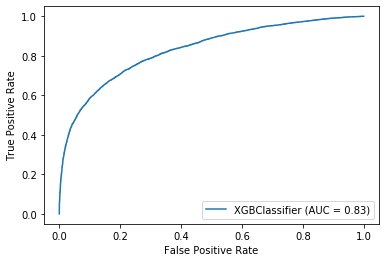

In [220]:
clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
clf.fit(X_train_scaled_20c2n,y_train)
metrics.plot_roc_curve(clf,X_val_scaled_20c2n,y_val)
plt.show()

**Logistic regression optimized for accuracy**

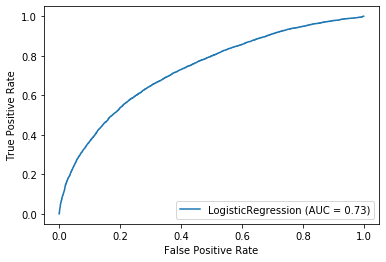

In [221]:
clf2=LogisticRegression(random_state=7, max_iter=10000,C= 10000, class_weight=
                              {0: 0.5, 1: 0.5}, penalty = 'l2')
 
clf2.fit(X_train_scaled_20c2n,y_train)
metrics.plot_roc_curve(clf2,X_val_scaled_20c2n,y_val)
plt.show()

**XGBoost optimized for the ROC AUC score**

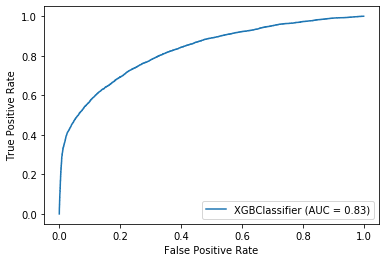

In [222]:
clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)
clf.fit(X_train_scaled_20c2n,y_train)
metrics.plot_roc_curve(clf,X_val_scaled_20c2n,y_val)
plt.show()

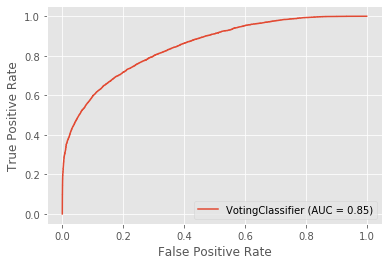

In [431]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

metrics.plot_roc_curve(voting_clf,X_val_scaled_20c2n,y_val)
plt.show()

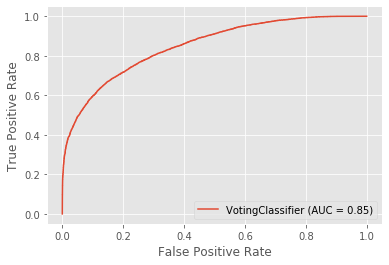

In [450]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})


xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)

#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

metrics.plot_roc_curve(voting_clf,X_val_scaled_20c2n,y_val)
plt.show()

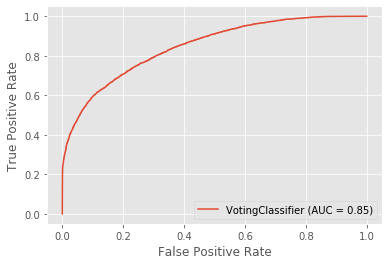

In [441]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

metrics.plot_roc_curve(voting_clf,X_val_scaled_20c2n,y_val)
plt.show()

### Precision-recall-curves

**XGBoost optimized for accuracy**

Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.73')

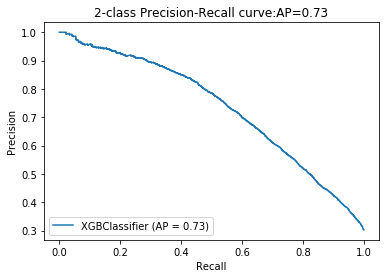

In [229]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
clf.fit(X_train_scaled_20c2n,y_train)
y_pred = clf.predict_proba(X_val_scaled_20c2n)[:,1]


curve_pr = plot_precision_recall_curve(clf,X_val_scaled_20c2n,y_val)

curve_pr.ax_.set_title('2-class Precision-Recall curve:'
                      'AP={0:0.2f}'.format(average_precision_score(y_val,y_pred)))

**Logistic regression optimized for accuracy**

Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.56')

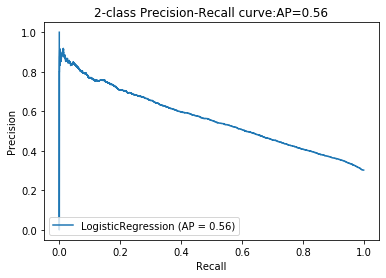

In [230]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
clf2= LogisticRegression(random_state=7, max_iter=10000,C= 10000, class_weight=
                              {0: 0.5, 1: 0.5}, penalty = 'l2')
clf2.fit(X_train_scaled_20c2n,y_train)
y_pred = clf2.predict_proba(X_val_scaled_20c2n)[:,1]


curve_pr = plot_precision_recall_curve(clf2,X_val_scaled_20c2n,y_val)

curve_pr.ax_.set_title('2-class Precision-Recall curve:'
                      'AP={0:0.2f}'.format(average_precision_score(y_val,y_pred)))

Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.76')

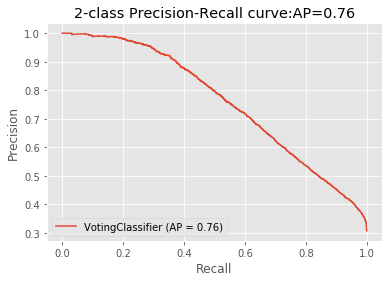

In [433]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

#clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                    # subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


curve_pr = plot_precision_recall_curve(voting_clf,X_val_scaled_20c2n,y_val)

curve_pr.ax_.set_title('2-class Precision-Recall curve:'
                      'AP={0:0.2f}'.format(average_precision_score(y_val,y_pred)))

Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.76')

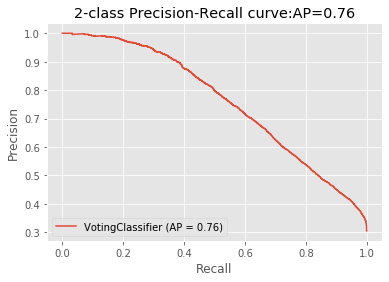

In [451]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)


#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

#clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                    # subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


curve_pr = plot_precision_recall_curve(voting_clf,X_val_scaled_20c2n,y_val)

curve_pr.ax_.set_title('2-class Precision-Recall curve:'
                      'AP={0:0.2f}'.format(average_precision_score(y_val,y_pred)))

Text(0.5, 1.0, '2-class Precision-Recall curve:AP=0.76')

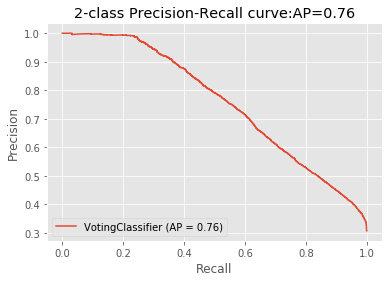

In [442]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve


from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})
xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)


#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)

#clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                    # subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
y_pred = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]


curve_pr = plot_precision_recall_curve(voting_clf,X_val_scaled_20c2n,y_val)

curve_pr.ax_.set_title('2-class Precision-Recall curve:'
                      'AP={0:0.2f}'.format(average_precision_score(y_val,y_pred)))

### Probability densities

**Logistic regression optimized for accuracy**

In [364]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


In [365]:
df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

In [366]:
clf2= LogisticRegression(random_state=7, max_iter=10000,C= 10000, class_weight=
                              {0: 0.5, 1: 0.5}, penalty = 'l2')
clf2.fit(X_train_scaled_20c2n,y_train)
churn_proba_lor = clf2.predict_proba(X_val_scaled_20c2n)[:,1]

In [367]:
churn_proba_lor_df = pd.DataFrame(churn_proba_lor)

In [368]:
df2_density = pd.concat([df2_density, churn_proba_lor_df,df_val_churn], axis =1)

In [369]:
df2_density.head()

,index,liefer_beginn_num,zahlung_weg_name_Rechnung,nl_aktivitaet,received_anzahl_6m,objekt_name_ZEIT Digital,zahlung_rhythmus_name_jährlich,openrate_3m,aboform_name_Negative Option,received_anzahl_zeitbrief_6m,...,kanal_andere,nl_opt_in_sum,rechnungsmonat_1,abo_registrierung_min_year_binned_11,sso_reg_1,avg_churn_lz,plz_3_prob,0,index,churn
0,121458,0.552632,0,0.085714,0.000000,0,0,0.000000,0,0.00,...,0,0.000000,0,0,0,0.347705,0.553846,0.204238,121458,0
1,74154,0.460526,1,0.171429,0.001068,0,1,0.000000,0,0.00,...,1,0.052632,0,0,0,0.389430,0.485470,0.427856,74154,1
2,87464,0.947368,1,0.314286,0.086538,0,1,0.131429,0,0.25,...,1,0.000000,0,1,1,0.536857,0.632479,0.314086,87464,0
3,33289,0.881579,1,0.228571,0.092949,1,0,0.127143,1,0.00,...,1,0.157895,0,1,1,0.662031,0.603419,0.496809,33289,0
4,32682,0.934211,1,0.228571,0.029915,1,0,0.021429,0,0.25,...,1,0.052632,0,0,1,0.731572,0.478632,0.522350,32682,1


In [370]:
df2_density.rename(columns={0:'churn_proba_log_reg'},inplace = True)

Text(0, 0.5, 'Density')

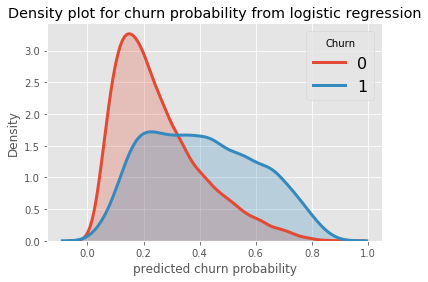

In [373]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_log_reg'],hist=False, kde=True,kde_kws={'linewidth':3, 'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from logistic regression')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')



**XGBoost optimized for accuracy**

In [340]:
clf= XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_xgb = clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [341]:
churn_proba_xgb_df = pd.DataFrame(churn_proba_xgb)

In [342]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_xgb_df,df_val_churn], axis =1)

In [343]:
df2_density.rename(columns={0:'churn_proba_xgb'},inplace = True)

Text(0, 0.5, 'Density')

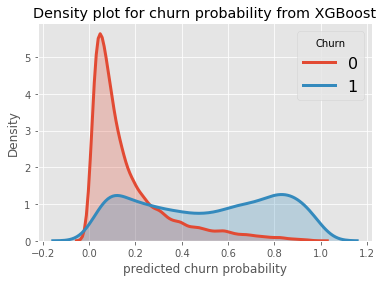

In [344]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_xgb'],hist=False, kde=True,kde_kws={'linewidth':3, 'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from XGBoost')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')



**K nearest neighbors optimized for accuracy and the Fbeta score**

In [334]:
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')
#XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
     #                subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf.fit(X_train_scaled_20a2n,y_train)
churn_proba_knn = knn_clf.predict_proba(X_val_scaled_20a2n)[:,1]

In [335]:
churn_proba_knn_df = pd.DataFrame(churn_proba_knn)

In [336]:
df2_density= X_val_scaled_20a2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_knn_df,df_val_churn], axis =1)

In [337]:
df2_density.rename(columns={0:'churn_proba_knn'},inplace = True)

Text(0, 0.5, 'Density')

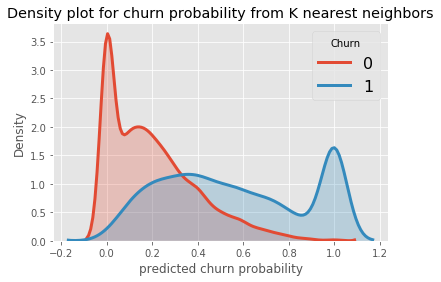

In [339]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_knn'],hist=False, kde=True,kde_kws={'linewidth':3, 'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from K nearest neighbors')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')



**Random forest optimized for the Fbeta score**

In [328]:
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy',class_weight= {0: 0.42, 1: 0.58})
#KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')
#XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
     #                subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
rfc_clf.fit(X_train_scaled_30bn,y_train)
churn_proba_rfc = rfc_clf.predict_proba(X_val_scaled_30bn)[:,1]

In [329]:
churn_proba_rfc_df = pd.DataFrame(churn_proba_rfc)

In [330]:
df2_density= X_val_scaled_30bn
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_rfc_df,df_val_churn], axis =1)

In [331]:
df2_density.rename(columns={0:'churn_proba_rfc'},inplace = True)

Text(0, 0.5, 'Density')

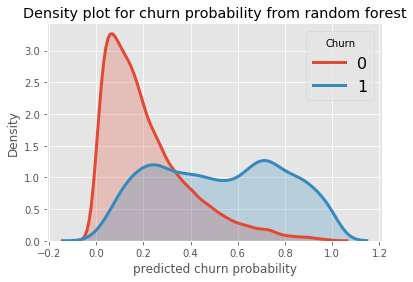

In [333]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_rfc'],hist=False, kde=True,kde_kws={'linewidth':3, 'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from random forest')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')



**XGBoost optimized for the Fbeta score**

In [323]:
clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)
#(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
 #                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_xgb = clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [324]:
churn_proba_xgb_df = pd.DataFrame(churn_proba_xgb)

In [325]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_xgb_df,df_val_churn], axis =1)

In [326]:
df2_density.rename(columns={0:'churn_proba_xgb'},inplace = True)

Text(0, 0.5, 'Density')

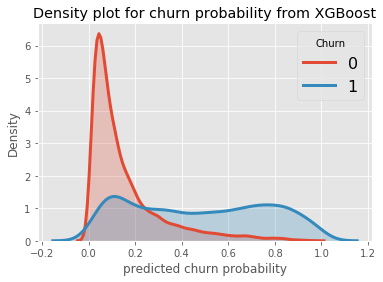

In [327]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_xgb'],hist=False, kde=True,kde_kws={'linewidth':3,'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from XGBoost')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')



**XGBoost optimized for the ROC AUC score**

In [394]:
clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha= 0.000001)
#(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
 #                   colsample_bytree=0.5, reg_alpha= 0.0001)
#(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
 #                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_xgb = clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [395]:
churn_proba_xgb_df = pd.DataFrame(churn_proba_xgb)

In [396]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_xgb_df,df_val_churn], axis =1)

In [397]:
df2_density.rename(columns={0:'churn_proba_xgb'},inplace = True)

Text(0, 0.5, 'Density')

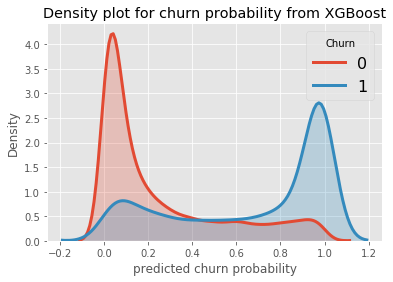

In [398]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_xgb'],hist=False, kde=True,kde_kws={'linewidth':3,'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from XGBoost')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')




In [434]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})




xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)




#clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                    subsample=1, colsample_bytree=1, reg_alpha= 0.000001)
#(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
 #                   colsample_bytree=0.5, reg_alpha= 0.0001)
#(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
 #                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_voc = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [435]:
churn_proba_voc_df = pd.DataFrame(churn_proba_voc)

In [436]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_voc_df,df_val_churn], axis =1)

In [437]:
df2_density.rename(columns={0:'churn_proba_voc'},inplace = True)

Text(0, 0.5, 'Density')

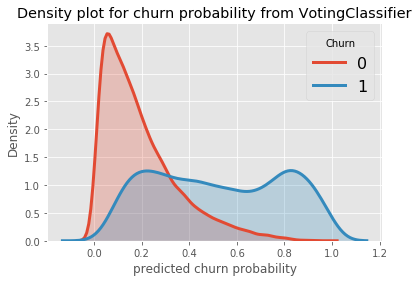

In [438]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_voc'],hist=False, kde=True,kde_kws={'linewidth':3,'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from VotingClassifier')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')




In [452]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
                    colsample_bytree=0.5, reg_alpha= 0.0001)


#xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)




#clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                    subsample=1, colsample_bytree=1, reg_alpha= 0.000001)
#(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
 #                   colsample_bytree=0.5, reg_alpha= 0.0001)
#(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
 #                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_voc = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [453]:
churn_proba_voc_df = pd.DataFrame(churn_proba_voc)

In [454]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_voc_df,df_val_churn], axis =1)

In [455]:
df2_density.rename(columns={0:'churn_proba_voc'},inplace = True)

Text(0, 0.5, 'Density')

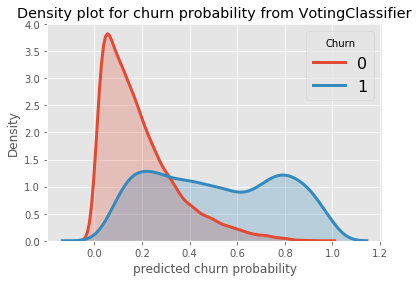

In [456]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_voc'],hist=False, kde=True,kde_kws={'linewidth':3,'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from VotingClassifier')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')




In [443]:
from sklearn.ensemble import VotingClassifier
rfc_clf = RandomForestClassifier(random_state=7, n_estimators = 200, max_features='auto', max_depth=32, 
                            criterion='entropy', class_weight= {0: 0.42, 1: 0.58})

xgb_clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
                     subsample=1, colsample_bytree=1, reg_alpha = 0.000001)

#xgb_clf = XGBClassifier(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
#                     subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
knn_clf = KNeighborsClassifier(metric='minkowski', n_neighbors= 32, p= 1, weights= 'distance')

voting_clf = VotingClassifier(estimators = [('rf',rfc_clf), ('xg',xgb_clf), ('kn',knn_clf)], voting = 'soft')

voting_clf.fit(X_train_scaled_20c2n,y_train)




#clf= XGBClassifier(random_state=7, scale_pos_weight=13, min_child_weight=2, max_depth=28,gamma=0,
#                    subsample=1, colsample_bytree=1, reg_alpha= 0.000001)
#(random_state=7, scale_pos_weight=0.68, max_depth=19, min_child_weight=2,gamma=0, subsample=1,
 #                   colsample_bytree=0.5, reg_alpha= 0.0001)
#(random_state=7, scale_pos_weight=0.9, max_depth=19, min_child_weight=2, gamma=0, 
 #                    subsample=1, colsample_bytree=0.5, reg_alpha= 0.0001)
#clf.fit(X_train_scaled_20c2n,y_train)
churn_proba_voc = voting_clf.predict_proba(X_val_scaled_20c2n)[:,1]

In [444]:
churn_proba_voc_df = pd.DataFrame(churn_proba_voc)

In [445]:
df2_density= X_val_scaled_20c2n
df2_density=df2_density.reset_index()


df_val_churn= y_val
df_val_churn=df_val_churn.reset_index()

df2_density = pd.concat([df2_density, churn_proba_voc_df,df_val_churn], axis =1)

In [446]:
df2_density.rename(columns={0:'churn_proba_voc'},inplace = True)

Text(0, 0.5, 'Density')

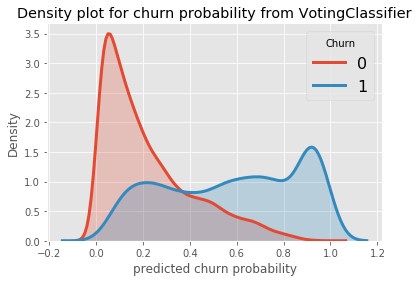

In [447]:
churn_groups=[0,1]
for churn_group in churn_groups:
    subset = df2_density[df2_density['churn']==churn_group]
    
    sns.distplot(subset['churn_proba_voc'],hist=False, kde=True,kde_kws={'linewidth':3,'shade':True},label=churn_group)
    
plt.legend(prop={'size':16},title = 'Churn')
plt.title('Density plot for churn probability from VotingClassifier')
plt.xlabel('predicted churn probability')
plt.ylabel('Density')


